# Описание проекта  

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.  

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?  

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.  

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.  
 

### Описание данных  

Каждая запись в логе — это действие пользователя, или событие.  
EventName — название события;  
DeviceIDHash — уникальный идентификатор пользователя;  
EventTimestamp — время события;  
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  


## СОДЕРЖАНИЕ <a id="soder"></a>

[Шаг 1. Открытие файла с данными и изучение общей информации](#shag1)  

[Шаг 2. Подготовка данных](#shag2) 

[2.1 Количество событий](#shag2.1)   
[2.2 Количество пользователей](#shag2.2)   
[2.3 Среднее кол-во событий на пользователя](#shag2.3)  
[2.4 Распределение данных во времени](#shag2.4)  
[2.5 Кол-во отрезаных данных](#shag2.5)  
[2.6 Проверка пользователей в группах](#shag2.6)  
    
[Шаг 3. Изучение воронки событий](#shag3)  
    [3.1 События](#shag3.1)  
    [3.2 Пользователи и события](#shag3.2)  
    [3.4 Порядок событий в воронке](#shag3.3)   

[Шаг 4. Изучение результатов эксперимента](#shag4)  
    [4.1 Кол-во пользователей в группах](#shag4.1)  
    [4.2 А1/А2/B - эксперимент (пользователи)](#shag4.2)  
    [4.3 Выводы](#shag4.3)  
    

# Шаг 1. Открытие файла с данными и изучение общей информации<a id="shag1"></a>  


In [1]:
from scipy import stats as st

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import re 
import math as mth

pd.set_option('display.max_colwidth', 500)

In [18]:
df = pd.read_csv('afisha.csv')
df = df.drop('Unnamed: 0', axis=1)

In [19]:
df.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
42172,OffersScreenAppear,1189296733004917712,1564718960,246
173535,MainScreenAppear,4864098461386716960,1565032060,248
10233,MainScreenAppear,1375557487947093308,1564648150,248
20253,MainScreenAppear,463651380788988263,1564664197,248
233989,CartScreenAppear,3337471580007169353,1565191463,246


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [21]:
df.describe()

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


In [22]:
df['EventName'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

**На первый взгляд очень хорошо. Пропусков нет. Выбросов нет.**

# Шаг 2. Подготовка данных <a id="shag2"></a>  


**Дальнейшие действия:**
    
    -Заменить названия столбцов на удобные для меня;  
   
    -Проверить пропуски и типы данных. Откорректировать, если нужно;  
    
    -Добавить столбец даты и времени, а также отдельный столбец дат;

**Заменим названия столбцов на более удобные:**

In [23]:
df.columns=['event', 'user', 'timestamp', 'group']
df.head(2)

,event,user,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


**Пропусков нет. Создадим столбец "datetime" с датой и временем:**

In [24]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.sample(5)

,event,user,timestamp,group,datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58


**Добавим столбец с датой:**

In [25]:
df['date'] = df['datetime'].dt.date
df.sample(5)

,event,user,timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


**Для удобства исправим значения в столбце "group": 246 и 247 — контрольные группы иправим на A1 и A2, а 248 — экспериментальная на B.**

In [26]:
def aab_group(gr):
    if gr==246:
        return 'A1'
    elif gr==247:
        return 'A2'
    elif gr==248:
        return 'B'
    else:
        return 'UnknownGroup'

df['group'] = df['group'].apply(aab_group)
df

,event,user,timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,A1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,A2,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,A1,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,A1,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,A1,2019-08-07 21:14:58,2019-08-07


In [27]:
df['group'].value_counts()

B     85747
A1    80304
A2    78075
Name: group, dtype: int64

***С группами всё в порядке***

**Еще раз проверим типы данных**

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      244126 non-null  object        
 1   user       244126 non-null  int64         
 2   timestamp  244126 non-null  int64         
 3   group      244126 non-null  object        
 4   datetime   244126 non-null  datetime64[ns]
 5   date       244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.2+ MB


**В столбце "date" поменяем тип на "datetime64"**

In [29]:
df['date'] = df['date'].astype('datetime64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      244126 non-null  object        
 1   user       244126 non-null  int64         
 2   timestamp  244126 non-null  int64         
 3   group      244126 non-null  object        
 4   datetime   244126 non-null  datetime64[ns]
 5   date       244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


**Проверим дубликаты:**

In [30]:
display('Кол-во дубликатов =',df.duplicated(['event', 'user', 'datetime', 'group']).sum())

'Кол-во дубликатов ='

413

***413 дубликатов, маловероятно что один и тот же пользователь в одной группе совершал одинаковые события в одно и тоже время, - дубликаты надо удалять. Но сначала посмотрим что там:***

In [31]:
df[df.duplicated()==True].sort_values(by=['user','datetime','event','group']).head(30)

,event,user,timestamp,group,datetime,date
130558,MainScreenAppear,33176906322804559,1564933075,B,2019-08-04 15:37:55,2019-08-04
130995,OffersScreenAppear,33176906322804559,1564933763,B,2019-08-04 15:49:23,2019-08-04
104108,CartScreenAppear,34565258828294726,1564857221,B,2019-08-03 18:33:41,2019-08-03
159302,PaymentScreenSuccessful,54903596035630984,1565011672,B,2019-08-05 13:27:52,2019-08-05
176813,PaymentScreenSuccessful,77364241990273403,1565044732,A1,2019-08-05 22:38:52,2019-08-05
189896,MainScreenAppear,91292479590032512,1565087723,A1,2019-08-06 10:35:23,2019-08-06
155464,MainScreenAppear,95206628315371849,1565005724,A2,2019-08-05 11:48:44,2019-08-05
110479,MainScreenAppear,170935625628929269,1564897487,A1,2019-08-04 05:44:47,2019-08-04
17037,CartScreenAppear,197027893265565660,1564659614,A1,2019-08-01 11:40:14,2019-08-01
23421,CartScreenAppear,197027893265565660,1564668928,A1,2019-08-01 14:15:28,2019-08-01


In [32]:
df[(df['user']==636437379427729086) & (df['datetime']=='2019-08-02 06:10:05')]

,event,user,timestamp,group,datetime,date
44071,PaymentScreenSuccessful,636437379427729086,1564726205,A2,2019-08-02 06:10:05,2019-08-02
44073,PaymentScreenSuccessful,636437379427729086,1564726205,A2,2019-08-02 06:10:05,2019-08-02
44074,PaymentScreenSuccessful,636437379427729086,1564726205,A2,2019-08-02 06:10:05,2019-08-02
44075,PaymentScreenSuccessful,636437379427729086,1564726205,A2,2019-08-02 06:10:05,2019-08-02


**Встретилось 4 дубликата.Удалим их.**

In [33]:
df = df.drop_duplicates()
display('Кол-во оставшихся дубликатов =', df.duplicated().sum())

'Кол-во оставшихся дубликатов ='

0

In [34]:
df = df.reset_index(drop=True)
df

,event,user,timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,A1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,A2,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,A1,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,A1,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,A1,2019-08-07 21:14:58,2019-08-07


***Всё сходится 243713 строк.***

## Мини-вывод:

В процессе обработки были: 
  - заменены названия столбцов  
  - были добавлены 2 столбца с датой и датой/временем,  
  - проверены и приведены к нормальным типы,  
  - заменены на более наглядные значения в столбце "group"   
  - и убрано 413 дубликатов

In [35]:
display('Кол-во уникальных пользователей по всей таблице =', df['user'].nunique())
sum = 0
for g in df['group'].unique():
    users_gr = df[df["group"]==g]["user"].nunique()
    sum = sum + users_gr
    display(f'В группе {g} - {users_gr} уникальных пользователей')
display(f'При сложениии 3 групп получается - {sum} уникальных пользователей')

'Кол-во уникальных пользователей по всей таблице ='

7551

'В группе A1 - 2489 уникальных пользователей'

'В группе B - 2542 уникальных пользователей'

'В группе A2 - 2520 уникальных пользователей'

'При сложениии 3 групп получается - 7551 уникальных пользователей'

**По всей таблице вышло 7551 уникальных пользователей.Также расчитали уникальных пользователей в отдельных группах.Позже просуммируя всех уникальных пользователей вышло 7551.Значения совпадают,а значит,пользователи, которые есть одновременно в 2 или 3 группах отсутствуют, в противном случае суммы 7551 не совпадали бы**

## 2.1 Количество событий<a id="shag2.1"></a>  

Посчитаем сколько всего событий в логе.

In [36]:
df['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

In [37]:
all_events = df['event'].count()
display('Всего событий в таблице =', all_events)

'Всего событий в таблице ='

243713

## 2.2 Количество пользователей <a id="shag2.2"></a>  


Посмотрим сколько всего пользователей в логе

In [38]:
users = df['user'].nunique()
display('Уникальных пользователей в таблице =', users)

'Уникальных пользователей в таблице ='

7551

## 2.3 Среднее кол-во событий на пользователя <a id="shag2.3"></a>  

Посмотрим сколько в среднем событий приходится на пользователя.

In [39]:
display("Среднее кол-во событий на пользователя =", (all_events / users).round(1))

'Среднее кол-во событий на пользователя ='

32.3

**Проверим насколько уместно среднее значение. Посмотрим распределение Кол-ва событий на пользователя:**

In [40]:
event_per_user = df.groupby('user')['event'].count()
event_per_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

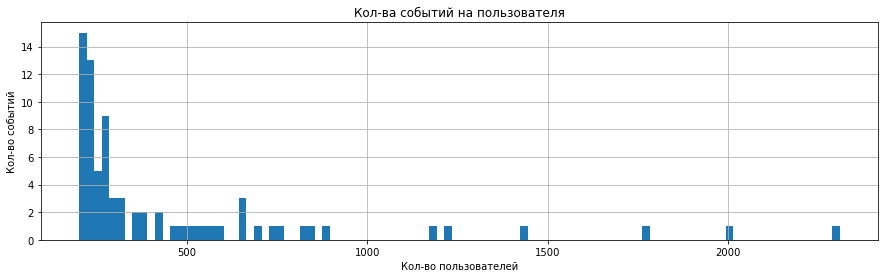

In [41]:
plt.figure(figsize=(15,4))
plt.hist(event_per_user, bins=100, range=(200,2310)) 
plt.xlabel('Кол-во пользователей')
plt.grid()
plt.ylabel('Кол-во событий')
plt.title('Кол-ва событий на пользователя');

***Как видно действительно есть "Выбросы" аж свыше 2000 событий. Рациональнее при такой ситуации использовать медиану, а не среднее:***

In [42]:
display("Усредненное (Медианное) Кол-во событий на пользователя =", event_per_user.median())

'Усредненное (Медианное) Кол-во событий на пользователя ='

20.0

## 2.4 Распределение данных во времени <a id="shag2.4"></a>  


Посмотрим за какой период у нас имеются данные,а потом, найдем максимальную и минимальную дату.Позже построим гистограмму по дате и времени.

In [43]:
display(f"Период данных которым мы располагаем: с {df['datetime'].min()} по {df['datetime'].max()}")
display(f"Это период размером : {df['datetime'].max() - df['datetime'].min()}")

'Период данных которым мы располагаем: с 2019-07-25 04:43:36 по 2019-08-07 21:15:17'

'Это период размером : 13 days 16:31:41'

***В общем период которым мы располагаем чуть меньше 2 недель.***

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


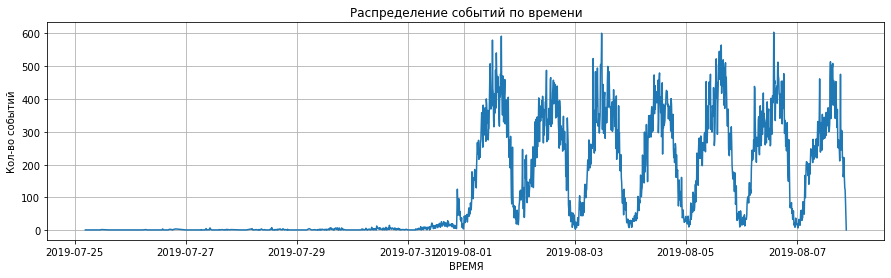

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


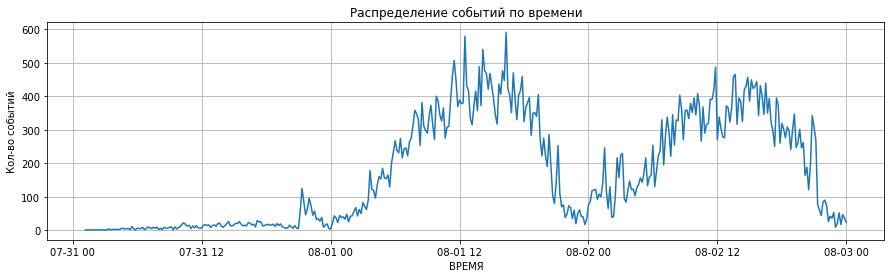

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


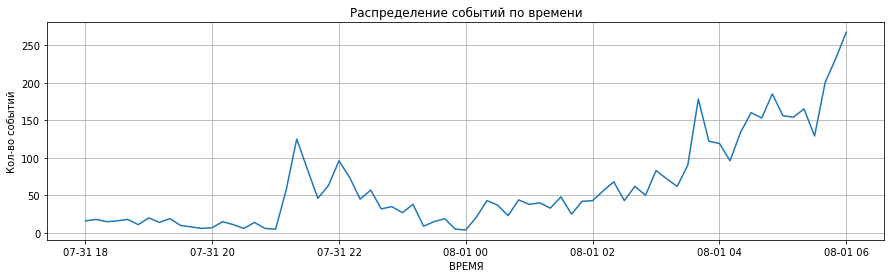

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


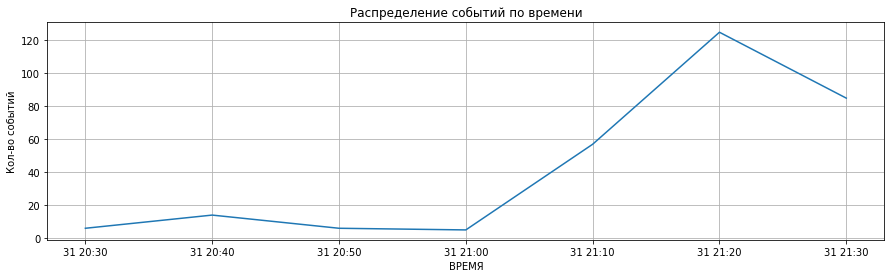

In [44]:
df['dt10m'] = df['datetime'].dt.round('10T')
dt10m_event = df.groupby('dt10m')['event'].count().reset_index()

lim = (
    ['2019-07-24','2019-08-10'],
    ['2019-07-31','2019-08-03'],
    ['2019-07-31 18:00:00', '2019-08-01 06:00:00'],
    ['2019-07-31 20:30:00','2019-07-31 21:30:00']
)

for period in lim:
    dt10m_per = dt10m_event[(dt10m_event['dt10m'] >= period[0]) & (dt10m_event['dt10m'] <= period[1])]
    plt.figure(figsize=(15,4))
    sns.lineplot(dt10m_per['dt10m'], dt10m_per['event'])
    plt.xlabel('ВРЕМЯ')
    plt.grid()
    plt.ylabel('Кол-во событий')
    plt.title('Распределение событий по времени');
    plt.show();

***Глядя на первый график можно сказать, что реально мы располагаем данными за первые 7 дней августа. Данные в июле характеризуются очень низкой активностью (очень мало событий). Также отлично видно, что распределение событий в августе идет циклично - с утра кол-во событий нарастает, днем держится на максимуме, вечером падает и ночью на минимуме.***  

***Хорошо видно, что данные за первую неделю сильно отличаются от второй. Скорее всего это была какая-то опробация или тестирование, а сбор данных уже начался со второй недели.Чтобы корректно провести анализ и тестирование надо "отрезать" события за июль, в силу их отсутствия. Из 3-го  и 4-го графиков можно выделить границу, где появляется существенное различие в распределении - это около 21:00 31 августа. Всё что раньше этого времени "отрежем" и будем проводить тестирование с данными примерно за 7 дней (которыми мы реально располагаем).***

In [45]:
df = df.loc[df['datetime'] > '2019-07-31 21:00:00'].reset_index(drop=True)
df.sort_values(by='datetime')

,event,user,timestamp,group,datetime,date,dt10m
0,MainScreenAppear,7701922487875823903,1564606857,A2,2019-07-31 21:00:57,2019-07-31,2019-07-31 21:00:00
1,MainScreenAppear,2539077412200498909,1564606905,A2,2019-07-31 21:01:45,2019-07-31,2019-07-31 21:00:00
2,OffersScreenAppear,3286987355161301427,1564606941,B,2019-07-31 21:02:21,2019-07-31,2019-07-31 21:00:00
3,OffersScreenAppear,3187166762535343300,1564606943,A2,2019-07-31 21:02:23,2019-07-31,2019-07-31 21:00:00
4,MainScreenAppear,1118952406011435924,1564607005,B,2019-07-31 21:03:25,2019-07-31,2019-07-31 21:00:00
...,...,...,...,...,...,...,...
241719,MainScreenAppear,4599628364049201812,1565212345,A2,2019-08-07 21:12:25,2019-08-07,2019-08-07 21:10:00
241720,MainScreenAppear,5849806612437486590,1565212439,A1,2019-08-07 21:13:59,2019-08-07,2019-08-07 21:10:00
241721,MainScreenAppear,5746969938801999050,1565212483,A1,2019-08-07 21:14:43,2019-08-07,2019-08-07 21:10:00
241722,MainScreenAppear,5746969938801999050,1565212498,A1,2019-08-07 21:14:58,2019-08-07,2019-08-07 21:10:00


**Убрали ненужные данные.**

## 2.5 Кол-во отрезаных данных <a id="shag2.5"></a>  


Посмотрим много ли событий и пользователей мы потеряли, отбросив данные.

In [46]:
new_users = df['user'].nunique()
display(f'Было пользователей = {users} / Стало = {new_users} / На сколько уменьшилось = {users-new_users} / Потяря = {round((users-new_users)/users*100,2)}%')

new_events = df['event'].count()
display(f'Было событий = {all_events} / Стало = {new_events} / На сколько уменьшилось = {all_events-new_events} / Потяря = {round((all_events-new_events)/all_events*100,2)}%')

'Было пользователей = 7551 / Стало = 7538 / На сколько уменьшилось = 13 / Потяря = 0.17%'

'Было событий = 243713 / Стало = 241724 / На сколько уменьшилось = 1989 / Потяря = 0.82%'

***Итак, отбросив неделю июля, мы потеряли 0,17% пользователей - что совсем незначительно, и 0,82% (незначительно)  событий - что тоже вполне допустимо.***

## 2.6 Проверка пользователей в группах <a id="shag2.6"></a>  


Посмотрим на имеющиеся выборки.

In [47]:
df['group'].value_counts()

B     84875
A1    79556
A2    77293
Name: group, dtype: int64

In [48]:
df.groupby('group')['user'].nunique()

group
A1    2484
A2    2517
B     2537
Name: user, dtype: int64

***Пользователей в каждой группе примерно по 2,5 тысячи, с незначительными отклонениями.***

## Мини-вывод

***В ходе проверки данных выяснилось, что данные предоставлены с 25 ююля по 7 августа. Кол-во событий, происходивших в июле почти незначительно по сравнению с августовскими. Из этого сделан вывод, что это было какое-либо  тестирование или что-то похожее. Поэтому июльские данные принято исключить из анализа. В ходе исключения(отрезания) было отрезано 0,17% пользователей и 0,82% событий - что вполне допустимо, и существенно не должно повлиять на дальнейший анализ. Среднее кол-во событий пользователя равно 32, ноесть выбросы поэтому рациональней использовать медиану равную 20. Кол-во пользователей в каждой группе осталось примерно 2,5 тысячи, а событий примерно по 80 тысяч. Что довольно ровные данные.***

# Шаг 3. Изучение воронки событий <a id="shag3"></a>  

## 3.1 События <a id="shag3.1"></a>  


Посмотрим какие события есть в логах и как часто они встречаются.

In [49]:
display('События в порядке убывания повторяемости:')
df['event'].value_counts()

'События в порядке убывания повторяемости:'

MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Tutorial                     1010
Name: event, dtype: int64

MainScreenAppear        - Главный экран  
OffersScreenAppear      - Экран Предложений  
CartScreenAppear        - Экран Корзины  
PaymentScreenSuccessful - Платеж Успешен  
Tutorial                - Руководство пользователя  

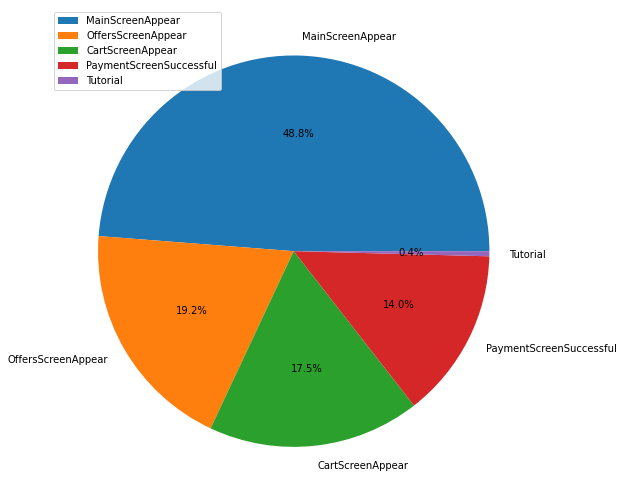

In [78]:
plt.figure(figsize=(9, 9))
fig = plt.pie(df['event'].value_counts(), labels=df['event'].value_counts().index, autopct='%1.1f%%')
plt.legend(loc='upper left')
plt.show()

***Почти половину (48,8%) событий это - "Главный экран", вторая половина это другие 3 события с близкими результатами - "Экран Предложений" (19,2%), "Экран Корзины" (17,5%) и Экран Платеж Успешен (14%). Остальное (0,4%) - "Руководство пользователя", почти незаметно, им похоже можно пренебречь в будущем.***

 ## 3.2 Пользователи и события <a id="shag3.2"></a>  

Посчитаем, сколько пользователей совершали каждое из этих событий.А потом отсортируем события по числу пользователей и посчитаем долю пользователей, которые хоть раз совершали событие. 

In [79]:
events_users = df.groupby('event').agg({'event':'count', 'user':'nunique'}).sort_values(by='user', ascending=False)
events_users.columns = ['n_events', 'users']
events_users = events_users.reset_index()
events_users['users_part_1event'] = (events_users['users'] / new_users * 100).round(1) # доля хотя бы раз совершивших событие
events_users

,event,n_events,users,users_part_1event
0,MainScreenAppear,117889,7423,98.5
1,OffersScreenAppear,46531,4597,61.0
2,CartScreenAppear,42343,3736,49.6
3,PaymentScreenSuccessful,33951,3540,47.0
4,Tutorial,1010,843,11.2


### Расшифровка

* Столбец "n_events" - кол-во событий  
* Столбец "users" - кол-во пользователей  
* Столбец "users_part_1event" - доля пользователей "получивших" хотя бы одно событие

**Построим график "События по числу пользователей"**

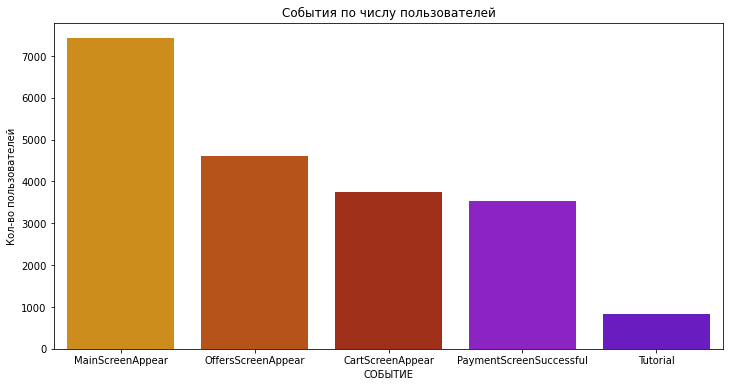

In [80]:
plt.figure(figsize=(12,6))
sns.barplot(y='users', x='event', data=events_users, palette='gnuplot_r');
plt.xlabel('СОБЫТИЕ')
plt.ylabel('Кол-во пользователей')
plt.title('События по числу пользователей')
plt.show();

**Построим график по долям пользователей**

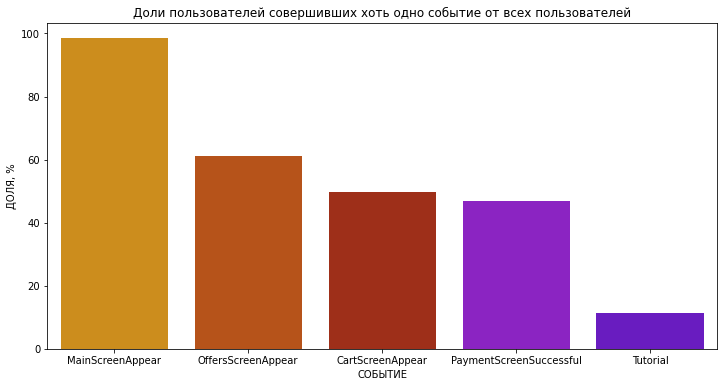

In [81]:
plt.figure(figsize=(12,6))
sns.barplot(y=('users_part_1event'), x='event', data=events_users, palette='gnuplot_r');
plt.xlabel('СОБЫТИЕ')
plt.ylabel('ДОЛЯ, %')
plt.title('Доли пользователей совершивших хоть одно событие от всех пользователей')
plt.show();

**Для понимания как распределены и насколько равномерно построим тоже самое по группам**

In [82]:
events_users_bygroup = df.groupby(['event','group']).agg({'event':'count', 'user':'nunique'})
events_users_bygroup.columns = ['n_events', 'users']
events_users_bygroup = events_users_bygroup.reset_index()

a1_users = df[df['group']=='A1']['user'].nunique()
a2_users = df[df['group']=='A2']['user'].nunique()
b_users = df[df['group']=='B']['user'].nunique()

def users_part_group(row):
    if row['group']=='A1':
        return (row['users'] / a1_users * 100)
    elif row['group']=='A2':
        return (row['users'] / a2_users * 100)
    elif row['group']=='B':
        return (row['users'] / b_users * 100)

events_users_bygroup['users_part_1event'] = events_users_bygroup.apply(users_part_group, axis=1)
events_users_bygroup['users_part_1event']= events_users_bygroup['users_part_1event'].round(1)
events_users_bygroup.sort_values(by=['group','users'], ascending=False).reset_index(drop=True)

,event,group,n_events,users,users_part_1event
0,MainScreenAppear,B,40740,2494,98.3
1,OffersScreenAppear,B,16465,1531,60.3
2,CartScreenAppear,B,15207,1231,48.5
3,PaymentScreenSuccessful,B,12110,1182,46.6
4,Tutorial,B,353,281,11.1
5,MainScreenAppear,A2,39294,2479,98.5
6,OffersScreenAppear,A2,15237,1524,60.5
7,CartScreenAppear,A2,12439,1239,49.2
8,PaymentScreenSuccessful,A2,9983,1158,46.0
9,Tutorial,A2,340,284,11.3


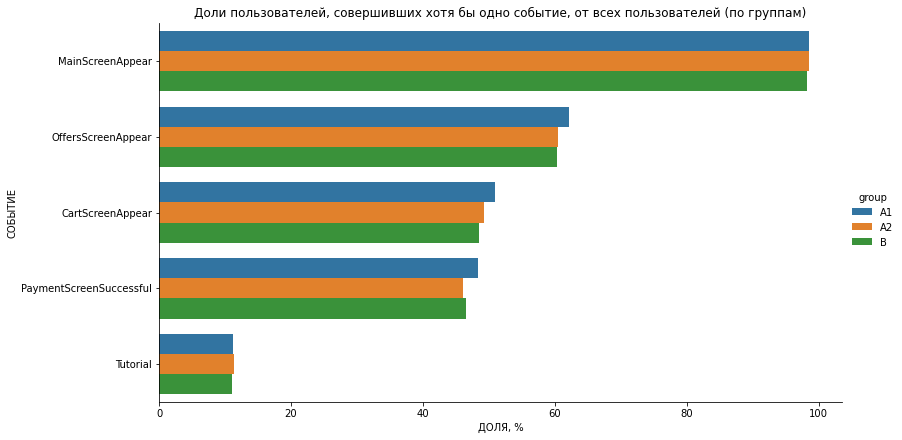

In [84]:
order = events_users['event']
order


sns.catplot(y="event", x="users_part_1event",
                hue="group", order=order, # col="time", 
                data=events_users_bygroup, kind="bar",
                height=6, aspect=2.0)
plt.ylabel('СОБЫТИЕ')
plt.xlabel('ДОЛЯ, %')
plt.title('Доли пользователей, совершивших хотя бы одно событие, от всех пользователей (по группам)');

***Данные по группам распределены довольно равномерно - результаты всех групп примерно похожи***

## Мини-вывод:

**"MainScreenAppear" №1 - название события, где самое большое число Событий, Пользователей и Доли пользователей, а дальше в каждом последующем названии каждый из показателей убывает - №2, №3, №4, №5. Воронка выглядит следующим образом:**

    1. MainScreenAppear - Главный экрана - Зашли на сайт
    2. OffersScreenAppear - Экран Предложений - Искали товар по каталогу
    3. CartScreenAppear - Экран Корзины - Добавили в корзину
    4. PaymentScreenSuccessful - Платеж Успешен - Оплатили
    5. Tutorial - Руководство пользователя - Изучали инструкцию

## 3.3 Порядок событий в воронке <a id="shag3.3"></a>  

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C надо посчитать отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

**По-скольку данные по событияем довольно равномерные будем анализировать всех пользователей не разбивая их по группам** 

**Посмотрим как выглядит воронка по пользователям на каждом событие:**

In [120]:
y = events_users['users']
x = events_users['event']

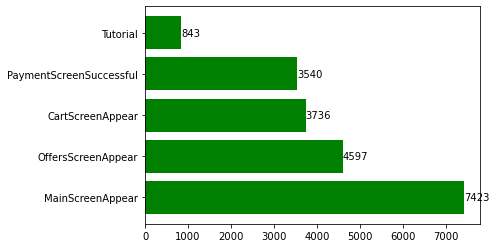

In [121]:
fig, ax = plt.subplots()
bars = ax.barh(x, y, color='green', align='center')


ax.bar_label(bars)
plt.show()

**Теперь рассчитаем сколько процентов переходит на каждый последующий шаг относительно предыдущего и также добавим столбец с кол-вом пользователей в процентах, которые переходили на последующее событие относительно изначального числа пользователей**

In [97]:
prev_users = events_users.loc[0,'users']
start_users = prev_users

for i in events_users.index:
    events_users.loc[i,'welcome_from_last'] = (events_users.loc[i,'users'] / prev_users * 100).round(1)
    events_users.loc[i,'welcome_from_start'] = (events_users.loc[i,'users'] / start_users * 100).round(1)
    prev_users = events_users.loc[i,'users']
events_users  

,event,n_events,users,users_part_1event,welcome_from_last,welcome_from_start
0,MainScreenAppear,117889,7423,98.5,100.0,100.0
1,OffersScreenAppear,46531,4597,61.0,61.9,61.9
2,CartScreenAppear,42343,3736,49.6,81.3,50.3
3,PaymentScreenSuccessful,33951,3540,47.0,94.8,47.7
4,Tutorial,1010,843,11.2,23.8,11.4


**Построим воронку - какой процент пользователей  перешел на следующий этап относительно первого этапа воронки:**

In [118]:
y = events_users['welcome_from_start']
x = events_users['event']

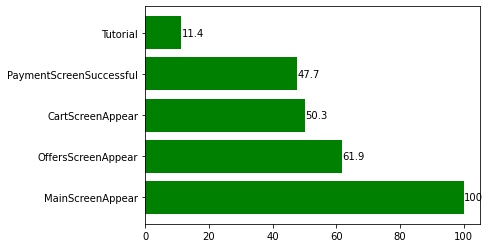

In [119]:
fig, ax = plt.subplots()
bars = ax.barh(x, y, color='green', align='center')


ax.bar_label(bars)
plt.show()

**Из этой воронки видно, что почти половина пользователей доходит до страницы "PaymentScreenSuccessful" с успешной оплатой. Очень хороший результат,учитывая, то что почти 40% отваливается после первого этапа!**

**Но возможен вариант, что те пользователи которые не были на первом этапе "MainScreenAppear", а появились уже на последующих, те которые зашли на сайт до начала сбора данных и т.д. А нам надо отследить всех от начала до оплаты. И процент "PaymentScreenSuccessful" уже будет совсем другой.**

In [103]:
funnel_users = df[df['event'] != 'Tutorial'].pivot_table(
        index=['user', 'group'], 
        columns='event', 
        values='datetime',
        aggfunc='min').reset_index()


In [107]:
step_1 = (~funnel_users['MainScreenAppear'].isna())
step_2 = step_1 & (funnel_users['OffersScreenAppear'] > funnel_users['MainScreenAppear'])
step_3 = step_2 & (funnel_users['CartScreenAppear'] > funnel_users['OffersScreenAppear'])
step_4 = step_3 & (funnel_users['PaymentScreenSuccessful'] > funnel_users['CartScreenAppear'])
n_MainScreenAppear = funnel_users[step_1].shape[0]
n_OffersScreenAppear = funnel_users[step_2].shape[0]
n_CartScreenAppear = funnel_users[step_3].shape[0]
n_PaymentScreenSuccessful = funnel_users[step_4].shape[0]

funnel_real = pd.DataFrame(columns = ['event', 'users'], data = [
    ['MainScreenAppear',n_MainScreenAppear],
    ['OffersScreenAppear',n_OffersScreenAppear],
    ['CartScreenAppear',n_CartScreenAppear],
    ['PaymentScreenSuccessful',n_PaymentScreenSuccessful]
])

In [108]:
funnel_real

,event,users
0,MainScreenAppear,7423
1,OffersScreenAppear,4203
2,CartScreenAppear,1781
3,PaymentScreenSuccessful,458


In [112]:
x = funnel_real['event']
y = funnel_real['users']

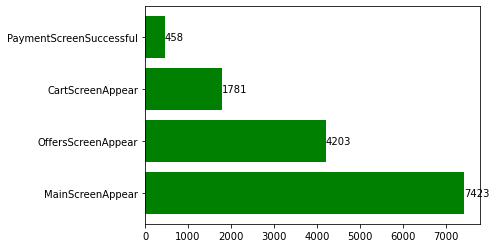

In [116]:
fig, ax = plt.subplots()
bars = ax.barh(x, y, color='green', align='center')


ax.bar_label(bars)
plt.show()

Судя по графику,от первоначальных пользователей проходят оплату меньше людей,чем на предыдущем графике, это уже больше похоже на правду.

Для большей уверенности в равномерности данных рассмотрим еще воронку в разрезе групп - "funnel_group":

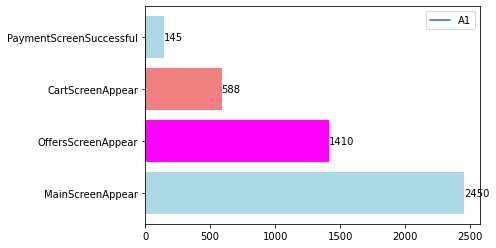

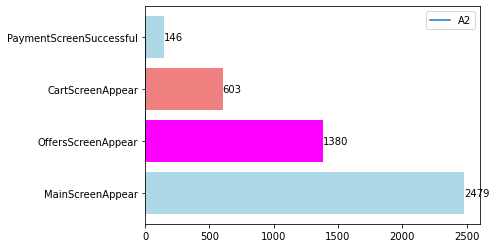

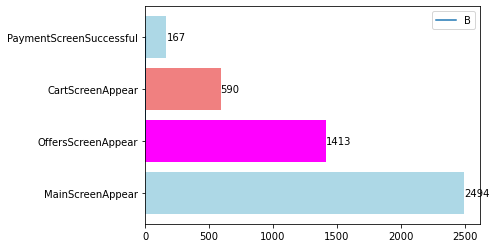

In [151]:
groups = ['A1','A2','B']
funnel_group ={}
for group in groups:
    funnel_group[group] =[]
    step_1 = (funnel_users['group']==group) & (~funnel_users['MainScreenAppear'].isna())
    step_2 = step_1 & (funnel_users['OffersScreenAppear'] > funnel_users['MainScreenAppear'])
    step_3 = step_2 & (funnel_users['CartScreenAppear'] > funnel_users['OffersScreenAppear'])
    step_4 = step_3 & (funnel_users['PaymentScreenSuccessful'] > funnel_users['CartScreenAppear'])
    funnel_group[group].append(funnel_users[step_1].shape[0])
    funnel_group[group].append(funnel_users[step_2].shape[0])
    funnel_group[group].append(funnel_users[step_3].shape[0])
    funnel_group[group].append(funnel_users[step_4].shape[0])
    
color = ['lightblue','fuchsia','lightcoral']
fig = plt.Figure()
for i in range(len(groups)):
    y = funnel_group[groups[i]]
    x = funnel_real['event']
    fig, ax = plt.subplots()
    bars = ax.barh(x, y,color=color, align='center')
    ax.bar_label(bars)
    ax.plot([1, 2, 3], label=groups[i])
    ax.legend()
    plt.show()

**Данные во всех трёх группах идут очень равномерно/пропорционально, и резельтаты соответственно очень похожи.**

## Вывод:

- Воронка продаж идет по следующему порядку:

    1. MainScreenAppear - Появление Главного экрана - Зашли на сайт
    2. OffersScreenAppear - Появление Экрана Предложений - Искали товар по каталогу
    3. CartScreenAppear - Появление Экрана Корзины - Добавили в корзину
    4. PaymentScreenSuccessful - Экран Платеж Успешен - Оплатили
    5. Tutorial - Руководство пользователя - Изучали инструкцию  

- На второй этап воронки попадает 62% пользователей, а 38% "теряются по дороге". Это большая цифра и здесь необходимо веб-аналитикам выянить почему так происходит, наверняка есть возможность исправить ситуацию;

- Пройдя по воронке, до экрана "4. PaymentScreenSuccessful" доходят 6-7% пользователей, то есть те кто становиться покупателями.

# Шаг 4. Изучение результатов эксперимента <a id="shag4"></a>  

# 4.1 Кол-во пользователей в группах <a id="shag4.1"></a> 

Посмотрим сколько пользователей в каждой экспериментальной группе

In [152]:
for g in groups:
    display(f"В группе '{g}' - {df[df['group']==g]['user'].nunique()} пользователей")

"В группе 'A1' - 2484 пользователей"

"В группе 'A2' - 2517 пользователей"

"В группе 'B' - 2537 пользователей"

# 4.2 Эксперименты <a id="shag4.2"></a> 

- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246(A1) и 247(A2).
- Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию).Потом подумаем можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. И в конце сделаем выводы.

**Запишем кол-во пользователей по каждой группе в таблицу "users_bygroup":**


In [153]:
users_bygroup = df.groupby('group')['user'].nunique()
users_bygroup['A1+A2'] = users_bygroup['A1'] + users_bygroup['A2']
users_bygroup

group
A1       2484
A2       2517
B        2537
A1+A2    5001
Name: user, dtype: int64

***Разбивка на группы довольно равномерная и можно считать её корректной.***

**Для проведения тестов составим таблицу "event_group_test", где указано число пользователей в воронке, идущей по событиям и по всем группам (исключая событие "Tutorial"):**

In [155]:
event_group_test = df[df['event']!='Tutorial'].pivot_table(
    index='event', 
    columns='group', 
    values='user',
    aggfunc='nunique').sort_values(by='A1', ascending=False)

event_group_test = event_group_test.reset_index()
event_group_test['A1+A2'] = event_group_test['A1'] + event_group_test['A2']
event_group_test['all'] = event_group_test['A1+A2'] + event_group_test['B']

event_group_test['percent_A1'] = (event_group_test['A1'] / users_bygroup['A1'] * 100).round(1)
event_group_test['percent_A2'] = (event_group_test['A2'] / users_bygroup['A2'] * 100).round(1)
event_group_test['percent_B'] = (event_group_test['B'] / users_bygroup['B'] * 100).round(1)
event_group_test['percent_A1+A2'] = ((event_group_test['A1'] + event_group_test['A2']) / \
                                  (users_bygroup['A1'] + users_bygroup['A2']) * 100).round(1)

event_group_test

group,event,A1,A2,B,A1+A2,all,percent_A1,percent_A2,percent_B,percent_A1+A2
0,MainScreenAppear,2450,2479,2494,4929,7423,98.6,98.5,98.3,98.6
1,OffersScreenAppear,1542,1524,1531,3066,4597,62.1,60.5,60.3,61.3
2,CartScreenAppear,1266,1239,1231,2505,3736,51.0,49.2,48.5,50.1
3,PaymentScreenSuccessful,1200,1158,1182,2358,3540,48.3,46.0,46.6,47.2


Теперь напишем функцию "test" для проведения тестов, на вход подаются 3 параметра: группа1, группа2, alpha(уровень статистической значимости):

In [162]:
def test(group1, group2, alpha):
    for i in event_group_test.index:
        p1 = event_group_test[group1][i] / users_bygroup[group1]
        # пропорция успехов во второй группе:
        p2 = event_group_test[group2][i] / users_bygroup[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_group_test[group1][i] + event_group_test[group2][i]) / 
                      (users_bygroup[group1] + users_bygroup[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_bygroup[group1] + 1/users_bygroup[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        display('{} p-значение: {}'.format(event_group_test['event'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        display('')
        
test("A1", "A2", 0.01)

'MainScreenAppear p-значение: 0.6756217702005545'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'OffersScreenAppear p-значение: 0.26698769175859516'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'CartScreenAppear p-значение: 0.2182812140633792'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'PaymentScreenSuccessful p-значение: 0.10298394982948822'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

Так как группы A1/A2 должны быть одинаковыми, то над ними и контроль жестче. Поэтому для проведения A/A тестирования был взят уровень статистической значимости равный 1%. По результатам A1/A2 тестирования для всех событий разница не оказалось значимой, поэтому эти группы считаем контрольными.

Так как для A/B теста не нужна высокая точность, то для дальнейших экспериментов буду выберать самый стандартный уровень значимости равный 5%. Дальше проведу еще 3 группы тестов: A1/B , A2/B , A1+A2/B

### A1/B - эксперимент:

In [163]:
test("A1", "B", 0.05)

'MainScreenAppear p-значение: 0.34705881021236484'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'OffersScreenAppear p-значение: 0.20836205402738917'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'CartScreenAppear p-значение: 0.08328412977507749'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'PaymentScreenSuccessful p-значение: 0.22269358994682742'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

### A2/B - эксперимент:

In [163]:
test("A2", "B", 0.05)

'MainScreenAppear p-значение: 0.34705881021236484'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'OffersScreenAppear p-значение: 0.20836205402738917'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'CartScreenAppear p-значение: 0.08328412977507749'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'PaymentScreenSuccessful p-значение: 0.22269358994682742'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

### А1+A2/B - эксперимент:

In [165]:
test("A1+A2", "B", 0.05)

'MainScreenAppear p-значение: 0.39298914928006035'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'OffersScreenAppear p-значение: 0.418998284007599'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'CartScreenAppear p-значение: 0.19819340844527744'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

'PaymentScreenSuccessful p-значение: 0.6452057673098244'

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


''

**Значимой разницы между группами во всех тестах не выявлено.**

# 4.3 Выводы <a id="shag4.3"></a>  

***В ходе анализа и эксперементов было сделано и выявлено:***

**1. Изучение данных:**  
  - В ходе проверки данных выяснилось, что данные предоставлены с 25 ююля по 7 августа. Кол-во событий, происходивших в июле почти незначительно по сравнению с августовскими. Из этого сделан вывод, что это было какое-либо тестирование или что-то похожее. Поэтому июльские данные принято исключить из анализа и оставить только период с 2019-07-31 21:00 часа. В ходе исключения(отрезания) было отрезано 0,17% пользователей и 0,82% событий - что вполне допустимо, и существенно не должно повлиять на дальнейший анализ.  
  - Среднее кол-во событий пользователя равно 32, но есть выбросы поэтому рациональней использовать медиану равную 20.  
  - Кол-во пользователей в каждой группе осталось примерно 2,5 тысячи, а событий примерно по 80 тысяч. Что довольно ровные данные.  

**2. Воронка продаж:**  
  - Идет по следующему порядку:
      1. MainScreenAppear - Появление Главного экрана - Зашли на сайт  
        -- Это самое популярное событие (117889 раз). Число пользователей совершивших самое популярное событие "MainScreenAppear" - 7423, примерно по 2,5 тысячи на группу. Доли пользователей совершивших самое популярное событие "MainScreenAppear" - 98,5%. По-скольку данные у нас "обрезаны", то вполне такое может быть, то есть существуют пользователи не совершившие первое событие (но совершившие другие). Также эти пользователи могли совершить его и еще раньще - до начала сбора данных.
      2. OffersScreenAppear - Появление Экрана Предложений - Искали товар по каталогу
      3. CartScreenAppear - Появление Экрана Корзины - Добавили в корзину
      4. PaymentScreenSuccessful - Экран Платеж Успешен - Оплатили
      5. Tutorial - Руководство пользователя - Изучали инструкцию  
             
  - На второй этап воронки попадает 62% пользователей, а 38% "теряются по дороге". Это большая цифра и здесь необходимо веб-аналитикам выянить почему так происходит, наверняка есть возможность исправить ситуацию;

  - Событие "5.Tutorial" не несет полезной нагрузки, поэтому его можно не принимать во внимание;

  - Пройдя по воронке, до экрана "4. PaymentScreenSuccessful" доходят 6-7% пользователей, то есть те кто становиться покупателями. Если брать просто кол-во пользователей, не "отслеживая" их по воронке то этот показатель аж 47%.  

**3. А1/А2/B - эксперименты:**  
  - В ходе тестирования были проведены 16 экспериментов:  
      - A1/A1   - 4 эксперемента (для каждого события) / уровень статистической значимости - 1%  
      - A1/B    - 4 эксперемента (для каждого события) / уровень статистической значимости - 5%  
      - A2/B    - 4 эксперемента (для каждого события) / уровень статистической значимости - 5%  
      - A1+A2/B - 4 эксперемента (для каждого события) / уровень статистической значимости - 5%  

     
  - Уровень статистической значимости в 10% был бы слишком велик так как в тесте не ожидаем изменений не менее чем 30% (в таком случае 10% погрешности измерений нас бы устроила). При уровне значимости 0.1 только одна из проверок покажет значимую разницу, между контрольной группой A1 и экспериментальной в доле перехода пользователей в корзину(CartScreenAppear), но эта разница будет не в пользу нашей экспериментальной группы. Но при уровне значимости 0.1 каждый десятый раз можно получать ложный результат, поэтому стоит применить изначально выбранный нами уровень значимости 0.05.


   - В результате всех и каждого  A/A/B эксперемента значимой разницы между группами не выявлено. Поэтому можно утверждать, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Тестирование можно назвать успешным - изменение шрифта не повлияло на поведение пользователей.